# Image Segmentation by Keras and U-Net

Image Segmentation 은 픽셀 기반의 이미지 분석을 진행하는 것이며, 컴퓨터 비전 분야의 가장 핵심이다. 이미지를 픽셀 단위로 분석하는 것의 목적은 각각의 픽셀을 특정 클래스로 분류해 object detection, image classifcation, image generation 등에 일조하는 것이다. 이 부분에서 해당 코드에서는 Keras 를 사용했으며, Segmentaton 을 위해 Mask-RCNN 모델을 사용했다.

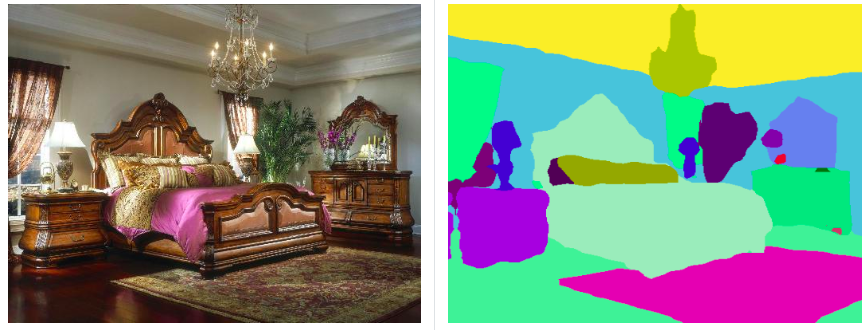

In [239]:
Image(filename=f'/home/lifeofpy/Desktop/seg.png')

Image Segmentation 은 해당 프로젝트에서 인물과 배경을 분리하는데 쓰였지만, 이외에도 적용 분야가 매우 다양하다. 먼저 의학 분야에서 종양이나 어떤 부분을 감지하는데 매우 큰 도움을 받을 수 있다. 또, 자율주행 자동차가 스스로 도로 위의 이미지를 분석해 자율주행을 하는데 도움을 받거나, 위성 이미지에서 지형을 분석하는 데에 도움을 받을 수도 있다.

### 1. 라이브러리 불러오기

In [265]:
import pandas as pd
import numpy as np
import os
import cv2

import shutil

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow
from skimage.transform import resize
from IPython.display import Image

import warnings
warnings.filterwarnings('ignore')

In [266]:
NUM_TEST_IMAGES = 100

IMG_HEIGHT = 128
IMG_WIDTH = 128
IMG_CHANNELS = 3

BATCH_SIZE = 100

SAMPLE_SIZE = 20000

### 2. AISegment.com 에서 Matting Human Dataset 다운로드 받기 

https://www.kaggle.com/laurentmih/aisegmentcom-matting-human-datasets

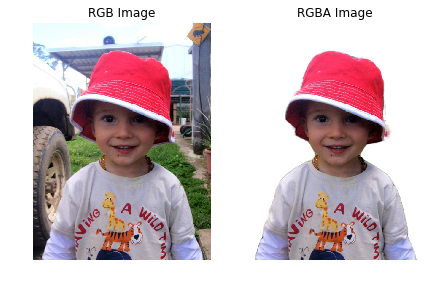

In [267]:
Image(filename=f'/home/lifeofpy/Desktop/SEG.png')

* Matting Human Dataset 은 위와 같이 인물과 배경이 같이 있는 사진에서 배경만을 제거하고 인물만을 png 파일로 저장할 수 있도록 만들어진 데이터셋 이다.

* Note: RGB 이미지는 3개의 채널을 가지지만, RGBA 이미지는 4개의 채널을 가진다. 4번째 채널은 바로 픽셀 투명성을 컨트롤한다. 'A'는 'Alpha Channel'을 의미한다. 이 채널은 0부터 255까지의 값을 가지고, 0은 투명함, 255는 불투명함을 뜻한다. 이 4번째 채널을 RGB 이미지에 더함으로써, 4번째 채널의 값을 다르게 해 배경을 투명으로(png 파일의 특성) 바꿀 수 있다.

### 3. Dataset 살펴보고 정제해주기

#### 1) clip_img

In [268]:
folder_list = os.listdir('/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img')

In [269]:
for i, folder_id in enumerate(folder_list):
    if i == 0:
        path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/'
        image_list = os.listdir(path)
        df_img = pd.DataFrame(image_list, columns = ['image_id'])
        df_img['folder_id'] = folder_id
        df_img['num_images_in_folder'] = len(image_list)
        df_img['type'] = 'image'
        
    else:
        path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/'
        image_list = os.listdir(path)
        df_1 = pd.DataFrame(image_list, columns = ['image_id'])
        df_1['folder_id'] = folder_id
        df_1['num_images_in_folder'] = len(image_list)
        df_1['type'] = 'image'
        
        # concat the dataframe
        df_img = pd.concat([df_img, df_1], axis = 0).reset_index(drop=True)
        
# remove a corrupt file
df_img = df_img[df_img['image_id'] != '._1803241125-00000005.jpg']

# reset the index
df_img = df_img.reset_index(drop=True)

        
df_img

,image_id,folder_id,num_images_in_folder,type
0,1803260216-00000001.jpg,1803260216,189,image
1,1803260216-00000188.jpg,1803260216,189,image
2,1803260216-00000067.jpg,1803260216,189,image
3,1803260216-00000107.jpg,1803260216,189,image
4,1803260216-00000289.jpg,1803260216,189,image
...,...,...,...,...
24474,1803280628-00000134.jpg,1803280628,133,image
24475,1803280628-00000387.jpg,1803280628,133,image
24476,1803280628-00000238.jpg,1803280628,133,image
24477,1803280628-00000113.jpg,1803280628,133,image


#### 2) matting mask

In [270]:
folder_list = os.listdir('/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/')

In [271]:
for i, folder_id in enumerate(folder_list):
    if i == 0:
        path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/'
        image_list = os.listdir(path)
        df_msk = pd.DataFrame(image_list, columns = ['mask_id'])
        df_msk['folder_id'] = folder_id
        df_msk['num_images_in_folder'] = len(image_list)
        df_msk['type'] = 'mask'
        
    else:
        path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/'
        image_list = os.listdir(path)
        df_1 = pd.DataFrame(image_list, columns = ['mask_id'])
        df_1['folder_id'] = folder_id
        df_1['num_images_in_folder'] = len(image_list)
        df_1['type'] = 'mask'
        
        # 데이터 프레임 합치기
        df_msk = pd.concat([df_msk, df_1], axis = 0).reset_index(drop=True)
        
# remove a corrupt file
df_msk = df_msk[df_msk['mask_id'] != '._1803241125-00000005.jpg']

# reset the index
df_msk = df_msk.reset_index(drop=True)

df_msk

,mask_id,folder_id,num_images_in_folder,type
0,1803260216-00000097.png,1803260216,189,mask
1,1803260216-00000472.png,1803260216,189,mask
2,1803260216-00000184.png,1803260216,189,mask
3,1803260216-00000138.png,1803260216,189,mask
4,1803260216-00000176.png,1803260216,189,mask
...,...,...,...,...
24474,1803280628-00000282.png,1803280628,133,mask
24475,1803280628-00000071.png,1803280628,133,mask
24476,1803280628-00000450.png,1803280628,133,mask
24477,1803280628-00000094.png,1803280628,133,mask


In [272]:
print('Number of Images:', df_img.shape[0])
print('Number of Masks:', df_msk.shape[0])

Number of Images: 24479
Number of Masks: 24479


#### 3) 두 개의 데이터 프레임을 같은 이미지로 합치기

In [273]:
def get_name(x):
    name = x.split('.')[0]
    return name

df_img['merge_col'] = df_img['image_id'].apply(get_name)
df_msk['merge_col'] = df_msk['mask_id'].apply(get_name)
df_data = pd.merge(df_img, df_msk, on='merge_col')

# select only specific columns that I need
df_data = df_data[['image_id', 'mask_id']]

df_data.to_csv('df_data.csv.gz', compression='gzip', index=False)

In [274]:
df_data.head()

,image_id,mask_id
0,1803260216-00000001.jpg,1803260216-00000001.png
1,1803260216-00000188.jpg,1803260216-00000188.png
2,1803260216-00000067.jpg,1803260216-00000067.png
3,1803260216-00000107.jpg,1803260216-00000107.png
4,1803260216-00000289.jpg,1803260216-00000289.png


#### 4) 시범적으로 이미지와 mask 를 프린트해보았다.

In [275]:
from IPython.display import Image

##### (1) Image

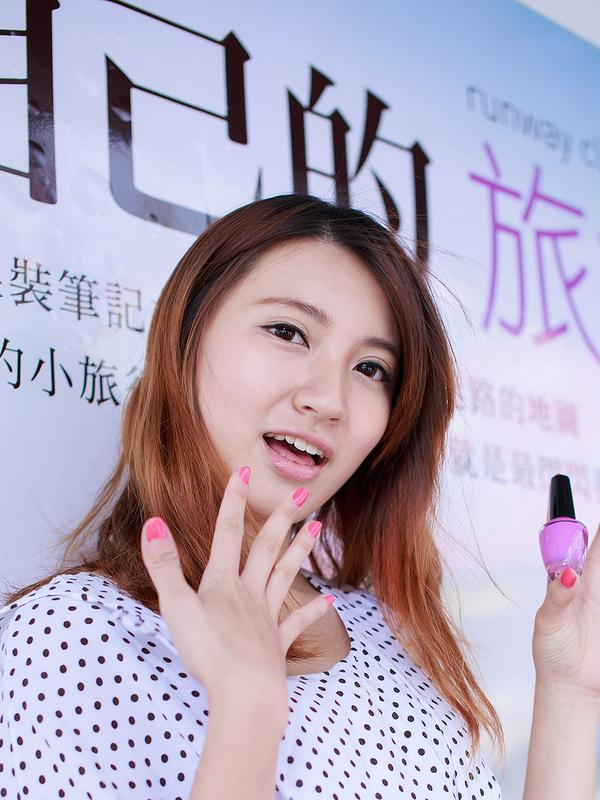

In [276]:
Image(filename=f'/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/1803280628/clip_00000000/1803280628-00000103.jpg')

##### (2) Mask

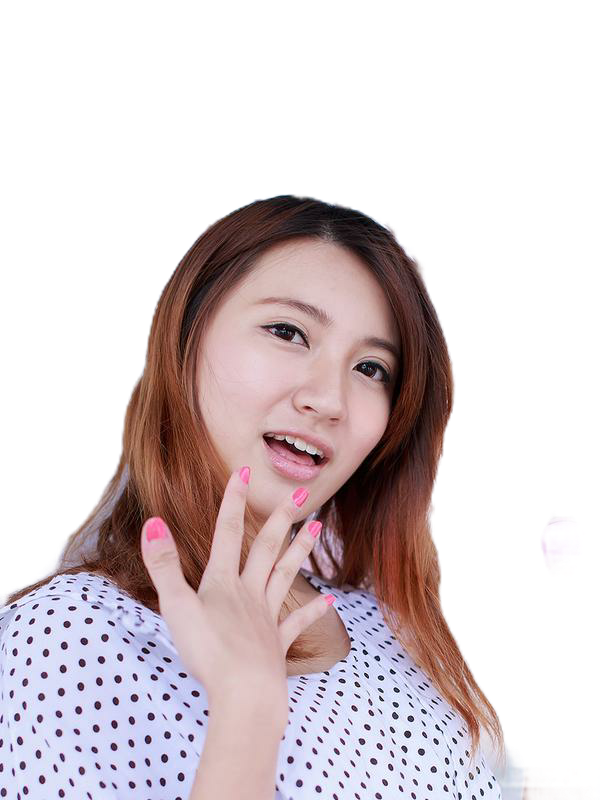

In [277]:
Image(filename=f'/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/1803280628/matting_00000000/1803280628-00000103.png')

#### 5) Alpha Channel 추출하기

Alpha Channel 은 RGBA 이미지의 4번째 채널이며, 픽셀의 투명성을 조절할 수 있다.

In [278]:
path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/1803280628/matting_00000000/1803280628-00000103.png'

In [279]:
# 이 과정에서 cv2.IMREAD_UNCHANGED 를 사용해주어야 한다. 
# cv2.IMREAD_UNCHANGED 는 이미지 파일을 Alpha Channel 까지 포함해 읽어들인다.
# 그렇지 않으면, 이미지는 오직 R,G,B 3가지 채널로만 읽힐 것이다.
rgba_image = cv2.imread(path, cv2.IMREAD_UNCHANGED)

In [280]:
# Select the 4th Alpha Channel
alpha = rgba_image[:,:,3]
print('Image Size:', rgba_image.shape)

Image Size: (800, 600, 4)


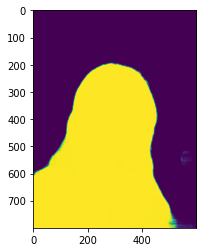

In [281]:
plt.imshow(alpha)

#### 6) Test Set 만들기

In [282]:
# create a test set
df_test = df_data.sample(NUM_TEST_IMAGES, random_state=101)

# reset the index
df_test = df_test.reset_index(drop=True)

# create a list of test images
test_images_list = list(df_test['image_id'])

# Rows that are not part of the test set
df_data = df_data[~df_data['image_id'].isin(test_images_list)]

In [283]:
print("Rows that are not Test Set:", df_data.shape)
print("Test Set:", df_test.shape)

Rows that are not Test Set: (24379, 2)
Test Set: (100, 2)


#### 7) Train Test Split 으로 Train Set, Validation Set 만들기

In [284]:
df_data = df_data.sample(SAMPLE_SIZE, random_state=101)
df_train, df_val = train_test_split(df_data, test_size=0.15, random_state=101)

# reset the index
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# print the size of the set
print("Train Set:", df_train.shape)
print("Validation Set:", df_val.shape)
print("Test Set:", df_test.shape)

Train Set: (17000, 2)
Validation Set: (3000, 2)
Test Set: (100, 2)


#### 8) Dataframe 을 CSV 파일로 변환해서 저장하기

이렇게 하면 매우 큰 데이터셋을 pandas 로 다루지 않고 csv 로 묶음 저장해 데이터를 다룰 수 있다.

In [285]:
df_train.to_csv('df_train.csv.gz', compression='gzip', index=False)
df_val.to_csv('df_val.csv.gz', compression='gzip', index=False)
df_test.to_csv('df_test.csv.gz', compression='gzip', index=False)

In [286]:
# check if the files were saved correctly
!ls

Makefile  demos		  df_train.csv.gz    mask_rcnn_coco.h5.1  setup.py
build	  df_data.csv.gz  df_val.csv.gz      model.h5		  wget-log
cocoapi   df_test.csv.gz  mask_rcnn_coco.h5  pycocotools


### 4. Data Generator 만들기

Data Generator 를 만들어 묶음 저장된 csv 파일을 정해진 batch_size 만큼 generate 할 수 있다면, data 를 chunking 해 코드를 간결화할 수 있다. For example, the last batch that is fed into a generator will be smaller than the others.

#### 1) Train Data 로 Generator 실행해서 결과 도출하기

In [287]:
def train_generator(batch_size=10):
    while True:
        for df in pd.read_csv('df_train.csv.gz', chunksize = batch_size):
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['mask_id'])
            
            # create empty X matrix - 3 channels
            X_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
            
            # create empty Y matrix = 1 channel
            Y_train = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, 1), dtype = np.bool)
            
            # create X_train
            for i, image_id in enumerate(image_id_list):
                folder_id = image_id.split('-')[0]
                path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/' + image_id
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                X_train[i] = image
            
            # create Y_train
            for j, mask_id in enumerate(mask_id_list):
                folder_id = mask_id.split('-')[0]
                path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/' + mask_id
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # select the alpha channel
                mask = mask[:, :, 3]
                
                # expand dimension from (800, 600) to (800, 600, 1)
                mask = np.expand_dims(mask, axis=-1) # axis = -1 는 현재 배열의 마지막 axis 를 의미
                
                # resize the mask
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into Y_train
                Y_train[j] = mask
                
            
            yield X_train, Y_train

In [288]:
# initialize the generator
train_gen = train_generator(batch_size = 100)

In [289]:
# run the generator
X_train, Y_train = next(train_gen)

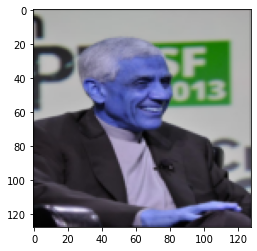

In [290]:
# print the first image in X_train
img = X_train[1, :, :, :]
plt.imshow(img)

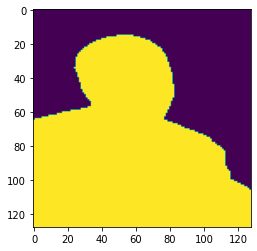

In [291]:
# print the first image in Y_train
msk = Y_train[1, :, :, 0]
plt.imshow(msk)

##### (1) X_train

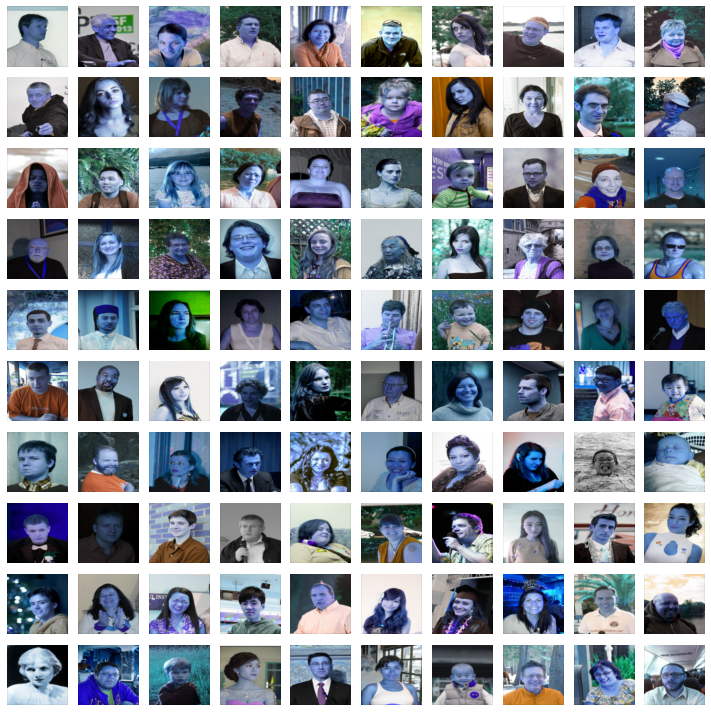

In [292]:
n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10, 10))
# sharex, sharey = 모든 x축 또는 y축이 같은 눈금을 사용하도록 한다.
for i in range(n**2):
    ax = axs[i//n, i%n]
    ax.imshow(X_train[i, :, :, :], cmap = plt.cm.gray)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

##### (2) Y_train

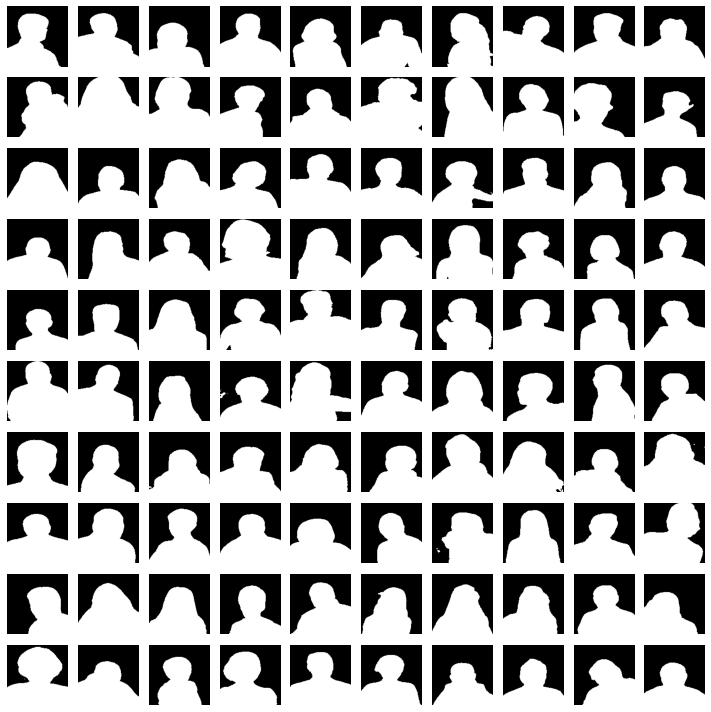

In [293]:
n = 10
fig, axs = plt.subplots(nrows=n, ncols=n, sharex=True, sharey=True, figsize=(10, 10))
# sharex, sharey = 모든 x축 또는 y축이 같은 눈금을 사용하도록 한다.
for i in range(n**2):
    ax = axs[i//n, i%n]
    ax.imshow(Y_train[i, :, :, 0], cmap = plt.cm.gray)
    ax.axis('off')
    
plt.tight_layout()
plt.show()

#### 2) Validation Data 로 Generator 실행해서 결과 도출하기

In [294]:
def val_generator(batch_size=10):
    while True:
        for df in pd.read_csv('df_val.csv.gz', chunksize = batch_size):
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['mask_id'])
            
            # create empty X matrix - 3 channels
            X_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
            
            # create empty Y matrix - 1 channel
            Y_val = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.bool)
            
            # create X_val
            for i, image_id in enumerate(image_id_list):
                folder_id = image_id.split('-')[0]
                path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/' + image_id
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                X_val[i] = image
            
            # create Y_val
            for j, mask_id in enumerate(mask_id_list):
                folder_id = mask_id.split('-')[0]
                path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/matting/' + str(folder_id) + '/matting_00000000/' + mask_id
                mask = cv2.imread(path, cv2.IMREAD_UNCHANGED)
                
                # select the alpha channel
                mask = mask[:, :, 3]
                
                # expand dimension from (800, 600) to (800, 600, 1)
                mask = np.expand_dims(mask, axis=-1) # axis = -1 는 현재 배열의 마지막 axis 를 의미
                
                # resize the mask
                mask = resize(mask, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                
                # insert the image into Y_val
                Y_val[j] = mask
                
            
            yield X_val, Y_val

In [295]:
val_gen = val_generator(batch_size=10)

In [296]:
X_val, Y_val = next(val_gen)
print(X_val.shape)
print(Y_val.shape)

(10, 128, 128, 3)
(10, 128, 128, 3)


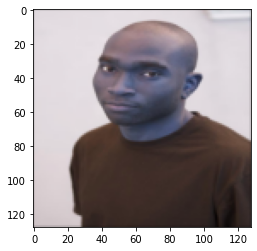

In [297]:
img = X_val[2, :, :, :]
plt.imshow(img)

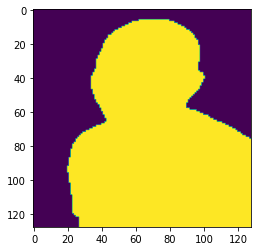

In [298]:
msk = Y_val[2, :, :, 0]
plt.imshow(msk)

#### 3) Test Data 로 Generator 실행해서 결과 도출하기

In [299]:
def test_generator(batch_size=10):
    while True:
        for df in pd.read_csv('df_val.csv.gz', chunksize = batch_size):
            image_id_list = list(df['image_id'])
            mask_id_list = list(df['mask_id'])
            
            # create empty X matrix - 3 channels
            X_test = np.zeros((len(df), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype = np.uint8)
            
            
            # create X_test
            for i, image_id in enumerate(image_id_list):
                folder_id = image_id.split('-')[0]
                path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/' + image_id
                image = cv2.imread(path)
                image = resize(image, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
                X_test[i] = image
                
            
            yield X_test

In [300]:
test_gen = test_generator(batch_size=10)

In [301]:
X_test = next(test_gen)

print(X_test.shape)

(10, 128, 128, 3)


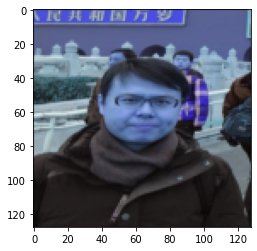

In [302]:
img = X_test[3, :, :, :]
plt.imshow(img)

In [303]:
# create the numpy matrix containing the test images in their 800*600 size.
test_id_list = list(df_test['image_id'])

X_test_orig = np.zeros((len(df_test), 800, 600, 3), dtype = np.uint8)

for i, image_id in enumerate(test_id_list):
    folder_id = image_id.split('-')[0]
    path = '/home/lifeofpy/LifeofPy/AI Photographer Project/Mask_RCNN/matting_human_half/clip_img/' + str(folder_id) + '/clip_00000000/' + image_id
    image = cv2.imread(path)
    X_test_orig[i] = image
    
X_test_orig.shape

(100, 800, 600, 3)

-------------------------------------------------------------------------------------

### 5. 모델 구현하고 학습하기

## Mask R-CNN Model Architecture using Keras

In [304]:
from keras.models import Model, load_model
from keras.layers import Input, UpSampling2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf

Keras Documentation 을 참고하여 최적화 함수를 Adam 에서 Nadam으로, 활성화 함수를 elu 에서 Sigmoid 로 변경했다.

In [305]:
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

# normalize the images
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (s)
c1 = Dropout(0.1) (c1)
c1 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p1)
c2 = Dropout(0.1) (c2)
c2 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p2)
c3 = Dropout(0.2) (c3)
c3 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p3)
c4 = Dropout(0.2) (c4)
c4 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (p4)
c5 = Dropout(0.3) (c5)
c5 = Conv2D(256, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c5)

u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u6)
c6 = Dropout(0.2) (c6)
c6 = Conv2D(128, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c6)

u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u7)
c7 = Dropout(0.2) (c7)
c7 = Conv2D(64, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c7)

u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u8)
c8 = Dropout(0.1) (c8)
c8 = Conv2D(32, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c8)

u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (u9)
c9 = Dropout(0.1) (c9)
c9 = Conv2D(16, (3, 3), activation='elu', kernel_initializer='he_normal', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])

model.compile(optimizer='nadam', loss='binary_crossentropy')

model.summary()

Model: "functional_19"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 128, 128, 3)  0           input_10[0][0]                   
__________________________________________________________________________________________________
conv2d_171 (Conv2D)             (None, 128, 128, 16) 448         lambda_9[0][0]                   
__________________________________________________________________________________________________
dropout_81 (Dropout)            (None, 128, 128, 16) 0           conv2d_171[0][0]                 
______________________________________________________________________________________

In [306]:
num_train_samples = len(df_train)
num_val_samples = len(df_val)
train_batch_size = BATCH_SIZE
val_batch_size = BATCH_SIZE

train_steps = np.ceil(num_train_samples/train_batch_size) # ceil: 각 원소의 소수자리 올림
val_steps = np.ceil(num_val_samples/val_batch_size)

In [307]:
# initialize the generators
train_gen = train_generator(batch_size=BATCH_SIZE)
val_gen = val_generator(batch_size=BATCH_SIZE)

## Train the Model

Keras 에서는 모델을 학습시킬 때 제네레이터로 생성된 배치로 학습시킬 경우에는 model.fit() 함수 대신에 model.fit_generator() 함수를 호출한다.

checkpoint 를 만들어 epoch당 validation loss 가 improved 되었는지 수시로 확인하도록 하며, early-stopper 를 두어 모델 학습 시 overfitting 을 방지한다. early-stopper 는 정해진 epoch 을 다 돌지 않아도 모델의 성능이 증가하지 않으면 학습을 멈추는 기능을 한다.

In [308]:
filepath = "model.h5"

earlystopper = EarlyStopping(patience=3, verbose=1)

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min')

callbacks_list = [earlystopper, checkpoint]

history = model.fit_generator(train_gen, steps_per_epoch=train_steps, epochs=20, 
                              validation_data=val_gen, validation_steps=val_steps,
                             verbose=1,
                             callbacks=callbacks_list)

Epoch 1/20
170/170 [==============================] - ETA: 0s - loss: 0.5039
Epoch 00001: val_loss improved from inf to 0.31071, saving model to model.h5
170/170 [==============================] - 1209s 7s/step - loss: 0.5039 - val_loss: 0.3107
Epoch 2/20
170/170 [==============================] - ETA: 0s - loss: 0.2455
Epoch 00002: val_loss improved from 0.31071 to 0.23082, saving model to model.h5
170/170 [==============================] - 1243s 7s/step - loss: 0.2455 - val_loss: 0.2308
Epoch 3/20
170/170 [==============================] - ETA: 0s - loss: 0.1618
Epoch 00003: val_loss improved from 0.23082 to 0.12973, saving model to model.h5
170/170 [==============================] - 1181s 7s/step - loss: 0.1618 - val_loss: 0.1297
Epoch 4/20
170/170 [==============================] - ETA: 0s - loss: 0.1131
Epoch 00004: val_loss improved from 0.12973 to 0.10610, saving model to model.h5
170/170 [==============================] - 1163s 7s/step - loss: 0.1131 - val_loss: 0.1061
Epoch 5/

## Make a Prediction

In [309]:
# initialize the test generator
test_gen = test_generator(batch_size=1)

model.load_weights(filepath = 'model.h5')
predictions = model.predict_generator(test_gen, steps=len(df_test), verbose=1)

100/100 [==============================] - 4s 42ms/step


In [310]:
predictions.shape

(100, 128, 128, 1)

## Process the Predictions

Alpha Channel 을 원본 800 * 600 사이즈의 이미지에 추가해야한다. 먼저 test_data 는 resize 나 reshape 를 진행한 적이 없으므로, 800*600으로 바꿔주고, Alpha Channel 을 추가해준다.

In [311]:
test_id_list = list(df_test['image_id'])

for i, image_id in enumerate(test_id_list):
    if i == 0:
        image = predictions[i]
        preds = resize(image, (800, 600))
        preds = preds.reshape((1, 800, 600, 1))
        
    else:
        image = predictions[i]
        image = resize(image, (800, 600))
        image = image.reshape((1, 800, 600, 1))
        preds = np.vstack((preds, image))
        
preds.shape

(100, 800, 600, 1)

## Threshold the predictions

여기서 예측값은 실제로 픽셀이 사람의 일부 또는 배경의 일부일 확률이다. 여기서 모든 값을 1 또는 0으로 변환하기 위해 예측값을 임계값으로 지정한다.

In [312]:
preds_test_thresh = (preds >= 0.5).astype(np.uint8)
preds_test_thresh.shape

print(preds_test_thresh.min())
print(preds_test_thresh.max())

0
1


## Change the values from 0/1 to 0/255

Alpha Channel 은 0부터 255까지의 값을 가지고 있어야 하므로, 255를 곱해준다.

In [313]:
alpha_preds = preds_test_thresh * 255

print(alpha_preds.min())
print(alpha_preds.max())

0
255


In [314]:
print(X_test_orig.shape)
print(alpha_preds.shape)

(100, 800, 600, 3)
(100, 800, 600, 1)


## Concat the predicted Alpha Channel to the Original Test images

In [315]:
predicted_masks = np.concatenate((X_test_orig, alpha_preds), axis = -1)

predicted_masks.shape

(100, 800, 600, 4)

## Display some Results

학습을 통해 만든 모델로 예측한 결과를 도출한다. Image Segmentation 은 어려운 것이다...

(-0.5, 599.5, 799.5, -0.5)

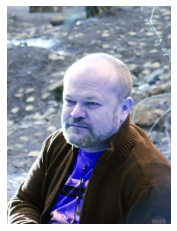

In [371]:
plt.subplot(1,1,1)
image = X_test_orig[30, :, :, :]
plt.imshow(image)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

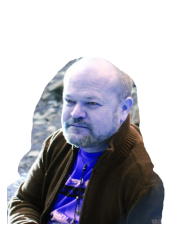

In [372]:
plt.subplot(1,1,1)
mask = predicted_masks[30, :, :, :] # # can also write as preds_orig[1]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

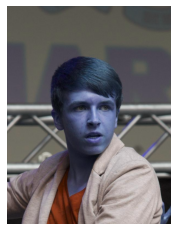

In [382]:
plt.subplot(1,1,1)
mask =  X_test_orig[92, :, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

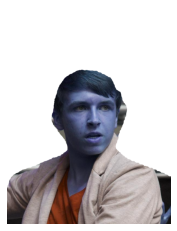

In [383]:
plt.subplot(1,1,1)
mask = predicted_masks[92, :, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

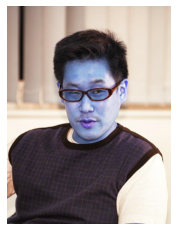

In [390]:
plt.subplot(1,1,1)
mask =  X_test_orig[32, :, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

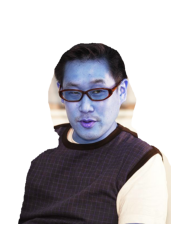

In [391]:
plt.subplot(1,1,1)
mask = predicted_masks[32, :, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

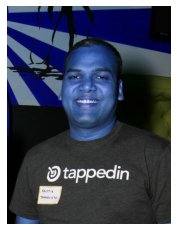

In [377]:
plt.subplot(1,1,1)
mask =  X_test_orig[61,:, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

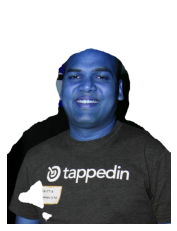

In [376]:
plt.subplot(1,1,1)
mask = predicted_masks[61, :, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

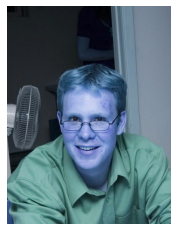

In [411]:
plt.subplot(1,1,1)
mask =  X_test_orig[19,:, :, :]
plt.imshow(mask)
plt.axis('off')

(-0.5, 599.5, 799.5, -0.5)

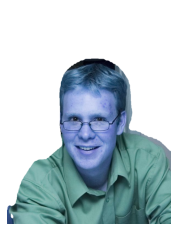

In [412]:
plt.subplot(1,1,1)
mask = predicted_masks[19, :, :, :]
plt.imshow(mask)
plt.axis('off')